In [1]:
import os
import quantumpropagator as qp
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

no display found. Using non-interactive Agg backend


In [2]:
fol = 'C:\\Users\\utente\\Desktop\\DATA\\'
#fn1 = os.path.join(fol,'datanewoneWithNACnow.npy')
fn2 = os.path.join(fol,'newExtrapolated_gammaExtrExag.pickle')

In [3]:
data = qp.pickleLoad(fn2)

In [4]:
data.keys()

dict_keys(['kinCube', 'smoCube', 'phis', 'geoCUBE', 'dipCUBE', 'gams', 'potCube', 'thes'])

In [5]:
pot = data['potCube']

In [6]:
phi_min, gam_min, the_min, state_min = np.unravel_index(pot.argmin(), pot.shape)
phi_min, gam_min, the_min, state_min

(29, 28, 55, 0)

In [17]:
phi_slice_min = pot[:,gam_min, the_min, state_min]
kin_slice_min = data['kinCube'][:,gam_min, the_min]  # -8.35513655e-08

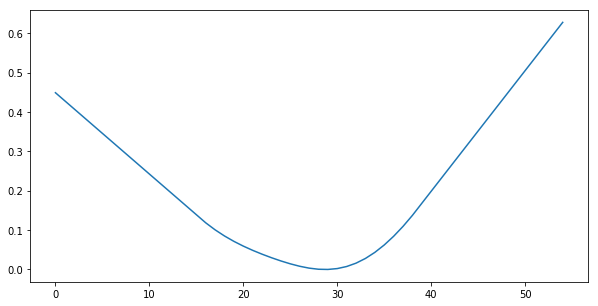

In [9]:
fig, ax0 = plt.subplots(1,1,figsize=(10,5))

ax0.plot(phi_slice_min);

In [11]:

def Cderivative1D_phi(GRID, phiL, dphi, Vm, K):

    I = -1j
    
    new = np.empty_like(GRID)

    for t in range(phiL):
        G = GRID[t]
        V = Vm[t]

        # derivatives in phi
        if t == 0:
            d2G_dt2 = (-GRID[t+2]+16*GRID[t+1]-30*GRID[t]) / (12 * dphi**2)

        elif t == 1:
            d2G_dt2 = (-GRID[t+2]+16*GRID[t+1]-30*GRID[t]+16*GRID[t-1]) / (12 * dphi**2)

        elif t == phiL-2:
            d2G_dt2 = (+16*GRID[t+1]-30*GRID[t]+16*GRID[t-1]-GRID[t-2]) / (12 * dphi**2)

        elif t == phiL-1:
            d2G_dt2 = (-30*GRID[t]+16*GRID[t-1]-GRID[t-2]) / (12 * dphi**2)

        else:
            d2G_dt2 = (-GRID[t+2]+16*GRID[t+1]-30*GRID[t]+16*GRID[t-1]-GRID[t-2]) / (12 * dphi**2)

        # T elements (9)
        Ttot = -8.35513655e-08 * d2G_dt2
        Vtot = V * G

        new[t] = I * (Ttot + Vtot)

    return(new)
